In [91]:
import pandas as pd
import matplotlib.pyplot as pp
import numpy as np
from plotly.offline import iplot, init_notebook_mode
import seaborn as sns
import warnings
import pickle
import time
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, Lambda
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import seaborn as sb
from pylab import *

import datetime as dt
#import chart_studio.tools as tls
import plotly.express as px 
#import cufflinks as cf            
import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')

init_notebook_mode()
plt.style.use('classic')

In [92]:
df = pd.read_csv('pollution_us_2000_2016.csv', sep = ',')
print ('Number of samples: ',len(df), '\n')
df.info()

Number of samples:  1746661 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1746661 entries, 0 to 1746660
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   State Code         int64  
 2   County Code        int64  
 3   Site Num           int64  
 4   Address            object 
 5   State              object 
 6   County             object 
 7   City               object 
 8   Date Local         object 
 9   NO2 Units          object 
 10  NO2 Mean           float64
 11  NO2 1st Max Value  float64
 12  NO2 1st Max Hour   int64  
 13  NO2 AQI            int64  
 14  O3 Units           object 
 15  O3 Mean            float64
 16  O3 1st Max Value   float64
 17  O3 1st Max Hour    int64  
 18  O3 AQI             int64  
 19  SO2 Units          object 
 20  SO2 Mean           float64
 21  SO2 1st Max Value  float64
 22  SO2 1st Max Hour   int64  
 23  SO2 AQI            float64
 24  CO Units           o

In [93]:
df.columns

Index(['Unnamed: 0', 'State Code', 'County Code', 'Site Num', 'Address',
       'State', 'County', 'City', 'Date Local', 'NO2 Units', 'NO2 Mean',
       'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI', 'O3 Units',
       'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'SO2 Units',
       'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI',
       'CO Units', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI'],
      dtype='object')

In [94]:
#informations of these columns are not needed

columns = ['State', 'Date Local', 'NO2 AQI', 'O3 AQI', 'SO2 AQI', 'CO AQI']

df = pd.DataFrame(df[columns])

In [95]:
df.describe(include='all')

State  Date Local       NO2 AQI        O3 AQI        SO2 AQI  \
count      1746661     1746661  1.746661e+06  1.746661e+06  873754.000000   
unique          47        5996           NaN           NaN            NaN   
top     California  2002-06-10           NaN           NaN            NaN   
freq        576142         640           NaN           NaN            NaN   
mean           NaN         NaN  2.389822e+01  3.605012e+01       7.115945   
std            NaN         NaN  1.516280e+01  1.978042e+01      11.937473   
min            NaN         NaN  0.000000e+00  0.000000e+00       0.000000   
25%            NaN         NaN  1.200000e+01  2.500000e+01       1.000000   
50%            NaN         NaN  2.300000e+01  3.300000e+01       3.000000   
75%            NaN         NaN  3.300000e+01  4.200000e+01       9.000000   
max            NaN         NaN  1.320000e+02  2.180000e+02     200.000000   

               CO AQI  
count   873338.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean         5.996595  
std          5.851836  
min          0.000000  
25%          2.000000  
50%          5.000000  
75%          8.000000  
max        201.000000

In [96]:
df_a = df[(df.State == 'Arizona')]
df_k = df[(df.State == 'Kansas')]
df_f = df[(df.State == 'Florida')]

In [97]:
df_new = pd.concat([df_a, df_k, df_f])

In [98]:
print('\n\033[1mChecking for missing Values:\033[0m')
print(df_new.isna().sum())


Checking for missing Values:
State             0
Date Local        0
NO2 AQI           0
O3 AQI            0
SO2 AQI       63611
CO AQI        63608
dtype: int64


In [99]:
df_new[228:232]

State  Date Local  NO2 AQI  O3 AQI  SO2 AQI  CO AQI
228  Arizona  2000-02-27       66      39     23.0     NaN
229  Arizona  2000-02-27       66      39     23.0    40.0
230  Arizona  2000-02-27       66      39      NaN     NaN
231  Arizona  2000-02-27       66      39      NaN    40.0

In [100]:
df_new.dropna(axis = 'index', inplace=True)

In [101]:
print('\n\033[1mChecking for missing Values:\033[0m')
print(df_new.isna().sum())


Checking for missing Values:
State         0
Date Local    0
NO2 AQI       0
O3 AQI        0
SO2 AQI       0
CO AQI        0
dtype: int64


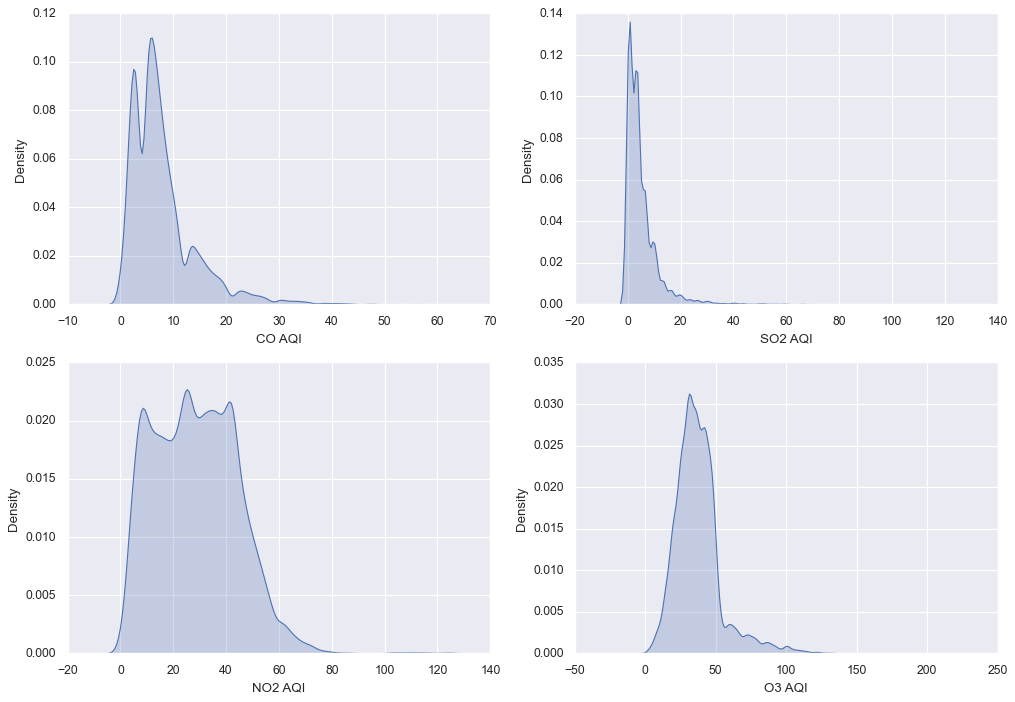

In [102]:
# Show all distribution plots simultaneously in four subplots 

sb.set(rc={"figure.figsize": (15, 10)})

subplot(2,2,1)
ax = sb.kdeplot(df_new['CO AQI'],shade=True)

subplot(2,2,2)
ax = sb.kdeplot(df_new['SO2 AQI'], shade=True)

subplot(2,2,3)
ax = sb.kdeplot(df_new['NO2 AQI'], shade=True)

subplot(2,2,4)
ax = sb.kdeplot(df_new['O3 AQI'], shade=True)

pp.show()

<AxesSubplot:xlabel='CO AQI', ylabel='Density'>

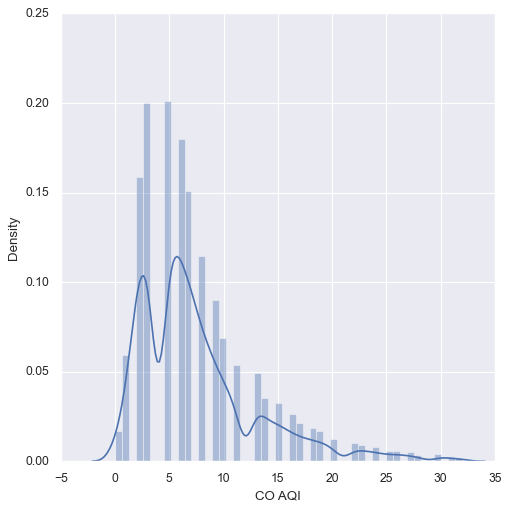

In [103]:
# To prevent outliers the common method of excluding data points that lie above
# the 99% quantile is applied below for all four variables.

figure(figsize=(7,7))

q1 = df_new['CO AQI'].quantile(0.99)

# Dropping observations that are greater than the 99% quantile, which lies above the value 33.
CO_outliers = df_new[df_new['CO AQI'] > q1]
df_new = df_new.drop(CO_outliers.index, axis= 0)

# Show the new data distribution after outliers were removed. 
sb.distplot(df_new['CO AQI'])

<AxesSubplot:xlabel='SO2 AQI', ylabel='Density'>

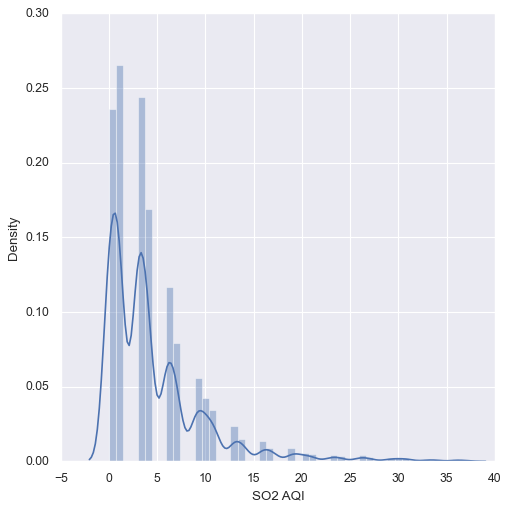

In [104]:
figure(figsize=(7,7))

q1 = df_new['SO2 AQI'].quantile(0.99)

# Dropping observations that are greater than the 99% quantile, which lies above the value 33.
CO_outliers = df_new[df_new['SO2 AQI'] > q1]
df_new = df_new.drop(CO_outliers.index, axis= 0)

# Show the new data distribution after outliers were removed. 
sb.distplot(df_new['SO2 AQI'])

<AxesSubplot:xlabel='NO2 AQI', ylabel='Density'>

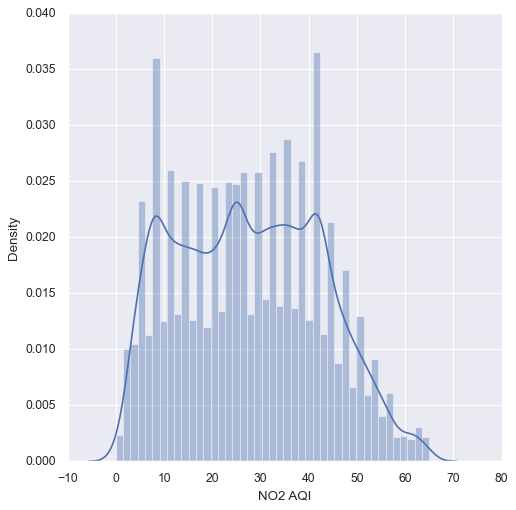

In [105]:
figure(figsize=(7,7))

q1 = df_new['NO2 AQI'].quantile(0.99)

# Dropping observations that are greater than the 99% quantile, which lies above the value 33.
CO_outliers = df_new[df_new['NO2 AQI'] > q1]
df_new = df_new.drop(CO_outliers.index, axis= 0)

# Show the new data distribution after outliers were removed. 
sb.distplot(df_new['NO2 AQI'])

<AxesSubplot:xlabel='O3 AQI', ylabel='Density'>

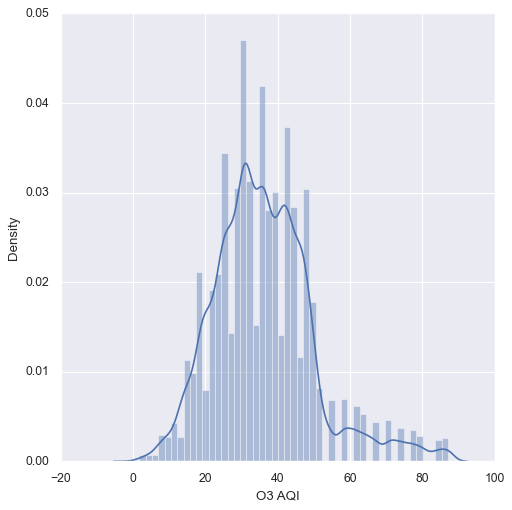

In [110]:
figure(figsize=(7,7))

q1 = df_new['O3 AQI'].quantile(0.99)

# Dropping observations that are greater than the 99% quantile, which lies above the value 33.
CO_outliers = df_new[df_new['O3 AQI'] > q1]
df_new = df_new.drop(CO_outliers.index, axis= 0)

# Show the new data distribution after outliers were removed. 
sb.distplot(df_new['O3 AQI'])

In [111]:
df_new.describe()

NO2 AQI        O3 AQI       SO2 AQI        CO AQI
count  30361.000000  30361.000000  30361.000000  30361.000000
mean      27.689338     36.090906      4.581437      7.496328
std       14.777703     13.870592      5.355033      5.477905
min        0.000000      0.000000      0.000000      0.000000
25%       15.000000     27.000000      1.000000      3.000000
50%       27.000000     35.000000      3.000000      6.000000
75%       39.000000     44.000000      6.000000      9.000000
max       65.000000     87.000000     37.000000     32.000000

In [112]:
#Convert Date Local to date format and extract year and month

# make copy of data first to avoid ~SettingWithCopyWarning~
df_new = df_new[df_new['Date Local'].notnull()].copy()
df_new['Year_Month'] = pd.to_datetime(df_new['Date Local']).dt.strftime('%Y-%m') #Year-Month
df_new['Year'] = pd.to_datetime(df_new['Date Local']).dt.strftime('%Y') #Year
df_new['Month'] = pd.to_datetime(df_new['Date Local']).dt.strftime('%m') #Year

In [113]:
fig = px.scatter(df_new,x='O3 AQI', y='NO2 AQI', 
             animation_frame='Year', animation_group='State',color='State',
             range_y=[0, 90], range_x=[0, 100])
fig.show()


In [114]:
df_new.columns

Index(['State', 'Date Local', 'NO2 AQI', 'O3 AQI', 'SO2 AQI', 'CO AQI',
       'Year_Month', 'Year', 'Month'],
      dtype='object')

In [115]:
df_new = df_new.drop(['Year_Month', 'Month', 'Year'], axis = 1)

In [116]:
df_new['Date Local'] = pd.to_datetime(df_new['Date Local'])
df_new.set_index('Date Local', inplace=True)

In [117]:
df_a = df_new[(df_new.State == 'Arizona')]
df_k = df_new[(df_new.State == 'Kansas')]
df_f = df_new[(df_new.State == 'Florida')]

In [118]:
df_k = df_k.sort_index(ascending=True, axis=0)
df_k = df_k.drop(['State'], axis = 1)
df_k=df_k.groupby(pd.Grouper(freq='D')).mean()

In [119]:
df_k.columns

Index(['NO2 AQI', 'O3 AQI', 'SO2 AQI', 'CO AQI'], dtype='object')

In [120]:
print('\n\033[1mChecking for missing Values:\033[0m')
print(df_k.isna().sum())


Checking for missing Values:
NO2 AQI    496
O3 AQI     496
SO2 AQI    496
CO AQI     496
dtype: int64


In [121]:
print('\n\033[1mFill missing values with previous value:\033[0m')
df_k = df_k.fillna(method="ffill")
print(df_k.isna().sum())


Fill missing values with previous value:
NO2 AQI    0
O3 AQI     0
SO2 AQI    0
CO AQI     0
dtype: int64


In [122]:
# normalize the dataset

scaler_feature = MinMaxScaler(feature_range=(0,1))
label_scaler = MinMaxScaler(feature_range=(0,1))
feature = scaler_feature.fit_transform(df_k.iloc[:,0:-1])
label = label_scaler.fit_transform(df_k.iloc[:,-1].values.reshape(-1,1))

In [123]:
df_k_t = np.concatenate((label, feature), axis=1)
df_k_t.shape

(5935, 4)

In [124]:
split = len(df_k.loc[:'2014-12-31',:])

X_train = df_k_t[:split,:]
X_train = tf.expand_dims(X_train, axis=-1)

y_train = df_k_t[:split,0]
 
X_test = df_k_t[split:,:]
X_test = tf.expand_dims(X_test, axis=-1)

y_test = df_k_t[split:,0]

In [125]:
# LSTM model with random parameters
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=128))
model.add(Dense(1))

# Since we have regression problem, we will use Mean Square Loss and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')


# Number of epoch and batch size:
np_epoch = 5
batch_size = 1
model.fit(X_train, y_train, epochs=np_epoch, batch_size=batch_size, verbose=2)

# Predcit stok prices on the test set
closing_price_standard = model.predict(X_test)
# we unnormalize predicted values to compare with real ones
closing_price_standard = label_scaler.inverse_transform(closing_price_standard)

Epoch 1/5
5479/5479 - 10s - loss: 0.0017
Epoch 2/5
5479/5479 - 9s - loss: 3.1516e-04
Epoch 3/5
5479/5479 - 9s - loss: 2.9557e-04
Epoch 4/5
5479/5479 - 9s - loss: 1.1169e-04
Epoch 5/5
5479/5479 - 9s - loss: 1.2437e-04


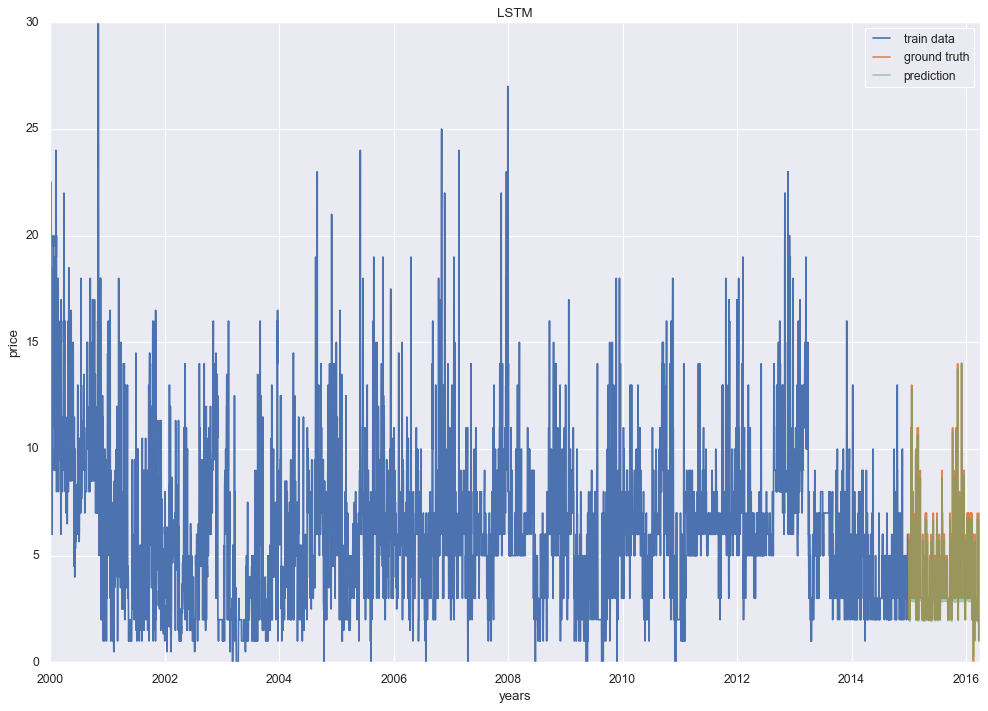

In [126]:
# LSTM random parameters

train = pd.DataFrame(df_k['CO AQI'][:split])
valid_st = pd.DataFrame(df_k['CO AQI'][split:])
valid_st['Prediction'] = closing_price_standard
plt.plot(train['CO AQI'], label= 'train data')
plt.plot(valid_st['CO AQI'], label= 'ground truth')
plt.plot(valid_st['Prediction'], label= 'prediction', alpha = 0.5)
plt.xlabel('years')
plt.ylabel('price')
plt.title('LSTM')
plt.legend()
plt.show()

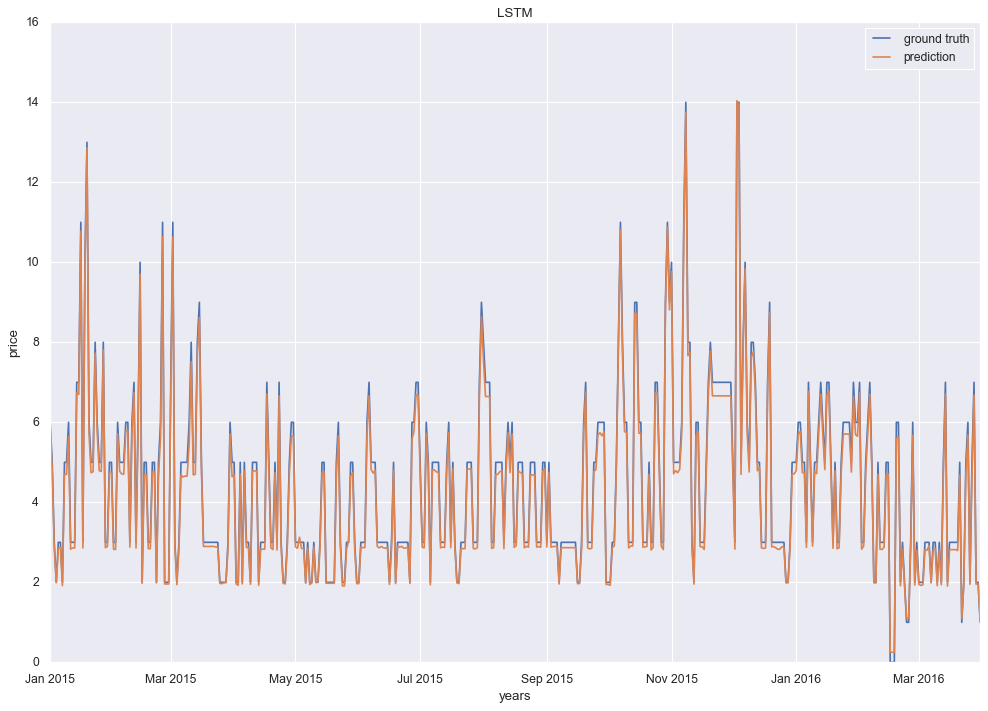

In [127]:
# LSTM random parameters prediction vs. ground truth

plt.plot(valid_st['CO AQI'], label= 'ground truth')
plt.plot(valid_st['Prediction'], label= 'prediction')
plt.xlabel('years')
plt.ylabel('price')
plt.title('LSTM')
plt.legend()
plt.savefig('LSTM_random_kansas.png', dpi = 500)
plt.show()

In [128]:
# Simpler Loop über unterschiedliche Epochen, Batch Size und Anzahl Neuronen

np_epoch = [10,25]
list_epoch = np.arange(0, len(np_epoch), 1)
results_5, results_10, results_20 = [],[],[]

batch_size = [2,4,8]
list_batch = np.arange(0, len(batch_size), 1)

neurons = [32,64,128]
list_neurons = np.arange(0, len(neurons), 1)

loss_file = []
loss_file = pd.DataFrame(loss_file)

def nans(shape, dtype = float):
    a = np.empty(shape, dtype)
    a.fill(np.nan)
    return a

column_names = ['Epoch','Batch', 'Neurons']
size = len(np_epoch) * len(batch_size) * len(neurons)
table_empty = nans([size, 3])
table_lstm = pd.DataFrame(table_empty, columns = column_names)

for i in list_epoch:
    print('\n\033[1mEpoch N°:\033[0m',np_epoch[i])
    #table_lstm.iloc[i, 0] = np_epoch[i]
    
    for j in list_batch:
        print('\033[1m   Batch Size:\033[0m',batch_size[j])
        #table_lstm.iloc[j, 1] = batch_size[j]
        
        for k in list_neurons:
            print('\033[1m      Neurons N°:\033[0m',neurons[k])  
            table_lstm.iloc[k, 2] = neurons[k]
            
            table_lstm.iloc[k, 0] = np_epoch[i]
            table_lstm.iloc[j, 1] = batch_size[j]
            
            # create and fit the LSTM network
            model = Sequential()
            model.add(LSTM(units=neurons[k], return_sequences=True, input_shape=(X_train.shape[1],1)))
            model.add(LSTM(units=neurons[k]))
            model.add(Dense(1))

            # Since we have regression problem, we will use Mean Square Loss and Adam optimizer
            model.compile(loss='mean_squared_error', optimizer='adam')


            # Number of epoch and batch size:
            history_callback = model.fit(X_train, y_train, epochs=np_epoch[i], batch_size=batch_size[j], verbose=2)

            # Predcit stok prices on the test set
            closing_price = model.predict(X_test)
            # we unnormalize predicted values to compare with real ones
            closing_price = label_scaler.inverse_transform(closing_price)
            
            loss_history = history_callback.history["loss"] #hiermit kann man die angezeigten loss "abspeichern"
            loss_history = pd.DataFrame(loss_history)
            loss_history = loss_history.transpose()
            
            loss_file = loss_file.append(loss_history)
            
loss_file.reset_index(drop=True, inplace=True)

lstm_overview = pd.concat([table_lstm,loss_file], axis = 1)


Epoch N°: 10
   Batch Size: 2
      Neurons N°: 32
Epoch 1/10
2740/2740 - 7s - loss: 0.0024
Epoch 2/10
2740/2740 - 5s - loss: 5.2665e-04
Epoch 3/10
2740/2740 - 5s - loss: 3.0906e-04
Epoch 4/10
2740/2740 - 5s - loss: 2.3172e-04
Epoch 5/10
2740/2740 - 5s - loss: 1.7681e-04
Epoch 6/10
2740/2740 - 5s - loss: 8.3446e-05
Epoch 7/10
2740/2740 - 5s - loss: 5.4455e-05
Epoch 8/10
2740/2740 - 5s - loss: 5.8763e-05
Epoch 9/10
2740/2740 - 5s - loss: 9.9061e-05
Epoch 10/10
2740/2740 - 5s - loss: 3.5054e-05
      Neurons N°: 64
Epoch 1/10
2740/2740 - 9s - loss: 0.0020
Epoch 2/10
2740/2740 - 8s - loss: 4.3503e-04
Epoch 3/10
2740/2740 - 8s - loss: 2.7275e-04
Epoch 4/10
2740/2740 - 8s - loss: 1.4088e-04
Epoch 5/10
2740/2740 - 7s - loss: 8.7581e-05
Epoch 6/10
2740/2740 - 8s - loss: 1.1136e-04
Epoch 7/10
2740/2740 - 8s - loss: 9.0058e-05
Epoch 8/10
2740/2740 - 7s - loss: 1.1291e-04
Epoch 9/10
2740/2740 - 8s - loss: 3.7086e-05
Epoch 10/10
2740/2740 - 8s - loss: 6.7599e-05
      Neurons N°: 128
Epoch 1/10


1370/1370 - 3s - loss: 8.8844e-05
Epoch 8/25
1370/1370 - 3s - loss: 8.0955e-05
Epoch 9/25
1370/1370 - 3s - loss: 6.3917e-05
Epoch 10/25
1370/1370 - 3s - loss: 6.9479e-05
Epoch 11/25
1370/1370 - 3s - loss: 3.6952e-05
Epoch 12/25
1370/1370 - 3s - loss: 5.2315e-05
Epoch 13/25
1370/1370 - 3s - loss: 3.1924e-05
Epoch 14/25
1370/1370 - 3s - loss: 3.6742e-05
Epoch 15/25
1370/1370 - 3s - loss: 2.7380e-05
Epoch 16/25
1370/1370 - 3s - loss: 1.2634e-04
Epoch 17/25
1370/1370 - 3s - loss: 1.9179e-05
Epoch 18/25
1370/1370 - 3s - loss: 1.7503e-05
Epoch 19/25
1370/1370 - 3s - loss: 2.4545e-05
Epoch 20/25
1370/1370 - 3s - loss: 1.3562e-05
Epoch 21/25
1370/1370 - 3s - loss: 1.5648e-05
Epoch 22/25
1370/1370 - 3s - loss: 2.4468e-05
Epoch 23/25
1370/1370 - 3s - loss: 6.4665e-06
Epoch 24/25
1370/1370 - 3s - loss: 1.1424e-05
Epoch 25/25
1370/1370 - 3s - loss: 1.4159e-05
      Neurons N°: 64
Epoch 1/25
1370/1370 - 5s - loss: 0.0027
Epoch 2/25
1370/1370 - 3s - loss: 4.5441e-04
Epoch 3/25
1370/1370 - 3s - loss:

In [43]:
lstm_overview.to_excel('lstm_kansas.xlsx')

### Model with ideal parameters

In [129]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=128))
model.add(Dense(1))

# Since we have regression problem, we will use Mean Square Loss and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')


# Number of epoch and batch size:
np_epoch = 25
batch_size = 2
model.fit(X_train, y_train, epochs=np_epoch, batch_size=batch_size, verbose=2)

# Predcit stok prices on the test set
closing_price_best = model.predict(X_test)
# we unnormalize predicted values to compare with real ones
closing_price_best = label_scaler.inverse_transform(closing_price_best)

Epoch 1/25
2740/2740 - 11s - loss: 0.0018
Epoch 2/25
2740/2740 - 10s - loss: 3.3390e-04
Epoch 3/25
2740/2740 - 10s - loss: 1.2005e-04
Epoch 4/25
2740/2740 - 10s - loss: 1.4208e-04
Epoch 5/25
2740/2740 - 10s - loss: 1.8184e-04
Epoch 6/25
2740/2740 - 10s - loss: 6.8870e-05
Epoch 7/25
2740/2740 - 10s - loss: 8.1369e-05
Epoch 8/25
2740/2740 - 10s - loss: 6.6746e-05
Epoch 9/25
2740/2740 - 10s - loss: 7.1262e-05
Epoch 10/25
2740/2740 - 10s - loss: 3.4434e-05
Epoch 11/25
2740/2740 - 10s - loss: 8.3742e-05
Epoch 12/25
2740/2740 - 10s - loss: 2.4203e-05
Epoch 13/25
2740/2740 - 10s - loss: 3.5635e-05
Epoch 14/25
2740/2740 - 12s - loss: 8.6425e-05
Epoch 15/25
2740/2740 - 12s - loss: 2.7430e-05
Epoch 16/25
2740/2740 - 11s - loss: 2.4634e-05
Epoch 17/25
2740/2740 - 10s - loss: 3.3157e-05
Epoch 18/25
2740/2740 - 10s - loss: 3.3965e-05
Epoch 19/25
2740/2740 - 10s - loss: 3.2027e-05
Epoch 20/25
2740/2740 - 10s - loss: 1.4697e-05
Epoch 21/25
2740/2740 - 10s - loss: 3.6882e-05
Epoch 22/25
2740/2740 - 10

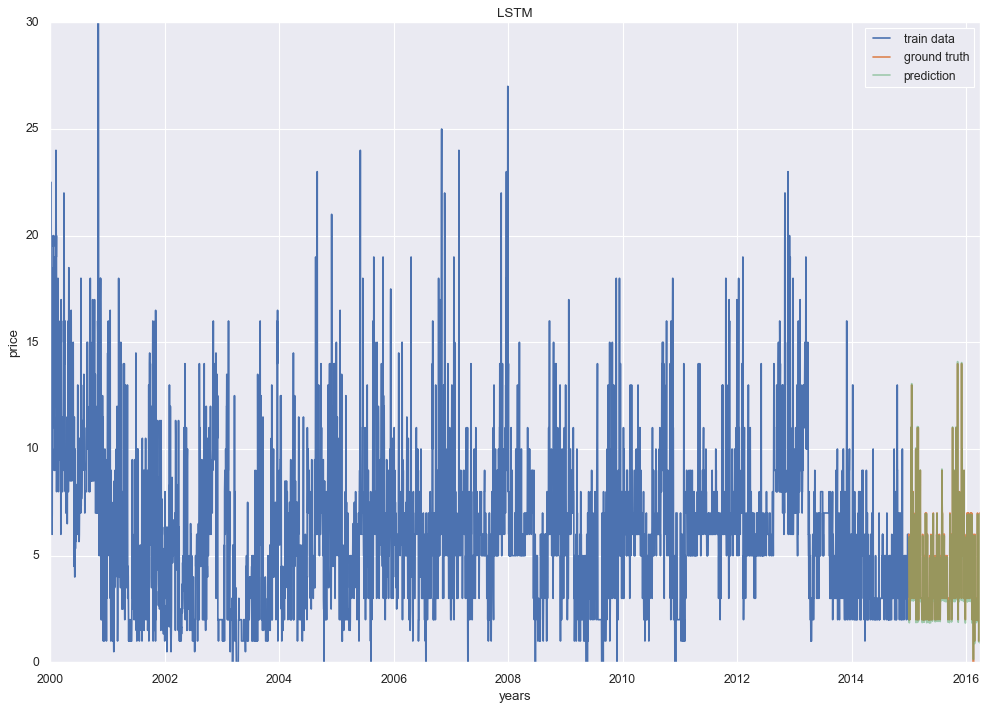

In [130]:
# LSTM with tuned parameters

train = pd.DataFrame(df_k['CO AQI'][:split])
valid = pd.DataFrame(df_k['CO AQI'][split:])
valid['Prediction'] = closing_price_best
plt.plot(train['CO AQI'], label= 'train data')
plt.plot(valid['CO AQI'], label= 'ground truth')
plt.plot(valid['Prediction'], label= 'prediction', alpha = 0.5)
plt.xlabel('years')
plt.ylabel('price')
plt.title('LSTM')
plt.legend()
plt.show()

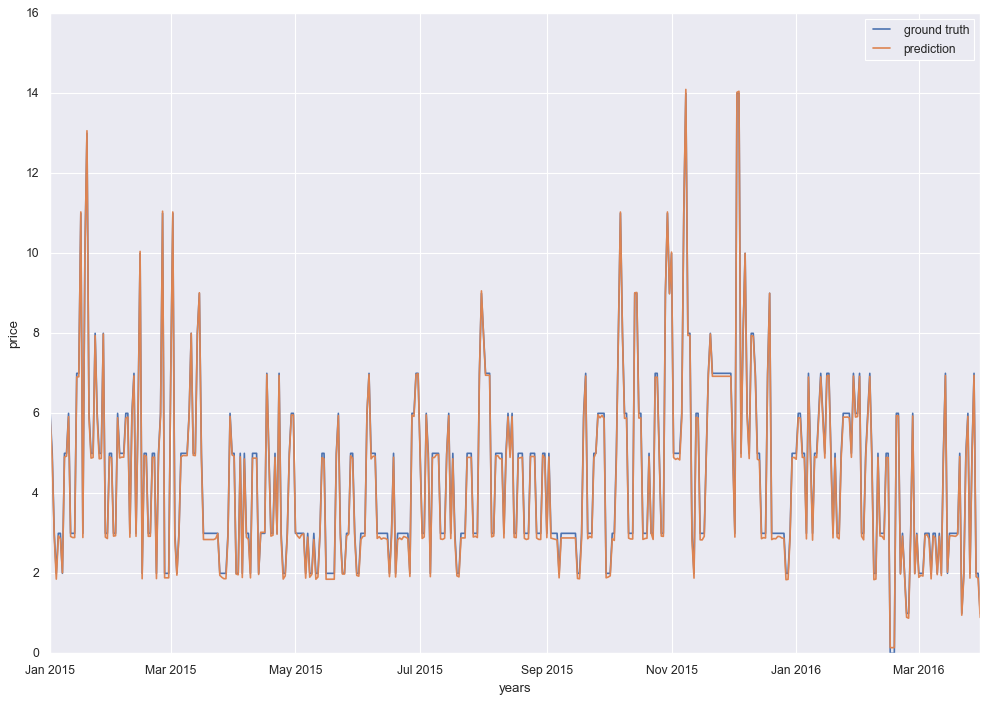

In [131]:
plt.plot(valid['CO AQI'], label= 'ground truth')
plt.plot(valid['Prediction'], label= 'prediction')
plt.xlabel('years')
plt.ylabel('price')
plt.legend()
plt.savefig('LSTM_tuned_kansas.png', dpi = 500)
plt.show()

In [132]:
Y = df_k['CO AQI']
X = df_k[['NO2 AQI', 'O3 AQI', 'SO2 AQI']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 CO AQI   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     440.4
Date:                Sun, 19 Jun 2022   Prob (F-statistic):          2.46e-258
Time:                        10:54:11   Log-Likelihood:                -15356.
No. Observations:                5935   AIC:                         3.072e+04
Df Residuals:                    5931   BIC:                         3.075e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7708      0.142     26.610      0.0

In [133]:
regression2 = pd.DataFrame(Y)

prediction = results.predict()

regression2['Prediction'] = prediction
regression2.head()

CO AQI  Prediction
Date Local                    
2000-01-01    10.0    6.213826
2000-01-02    12.0    4.854514
2000-01-03    13.0    5.298813
2000-01-04    15.5    4.731682
2000-01-05    16.0    5.717740

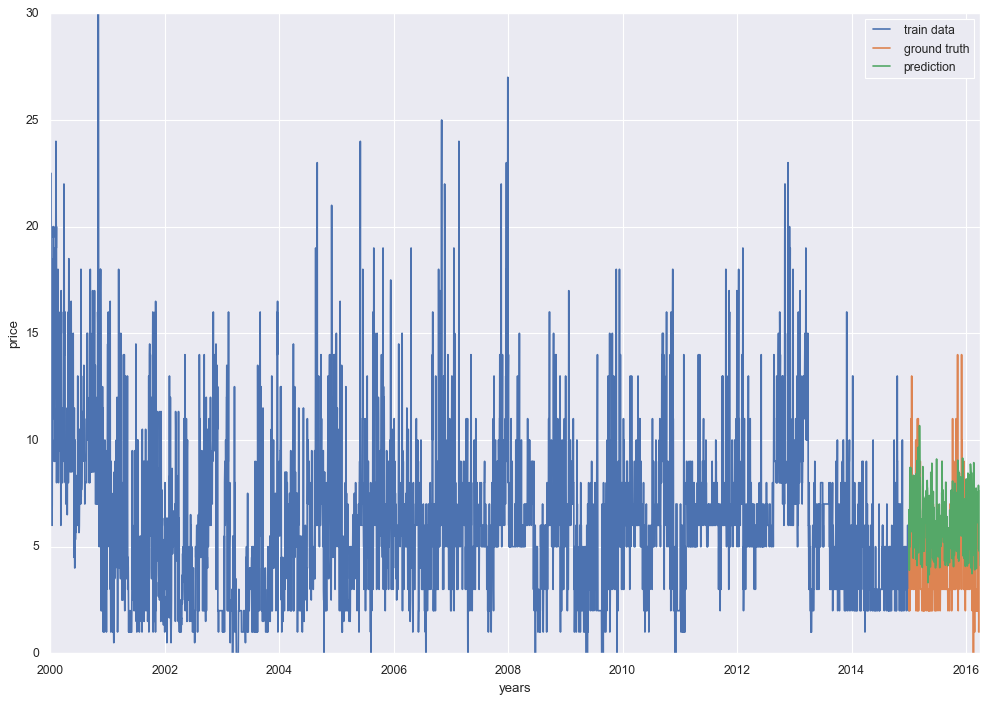

In [134]:
plt.plot(regression2['CO AQI'][:split], label = 'train data')
plt.plot(regression2['CO AQI'][split:], label = 'ground truth')
plt.plot(regression2['Prediction'][split:], label = 'prediction')
plt.xlabel('years')
plt.ylabel('price')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

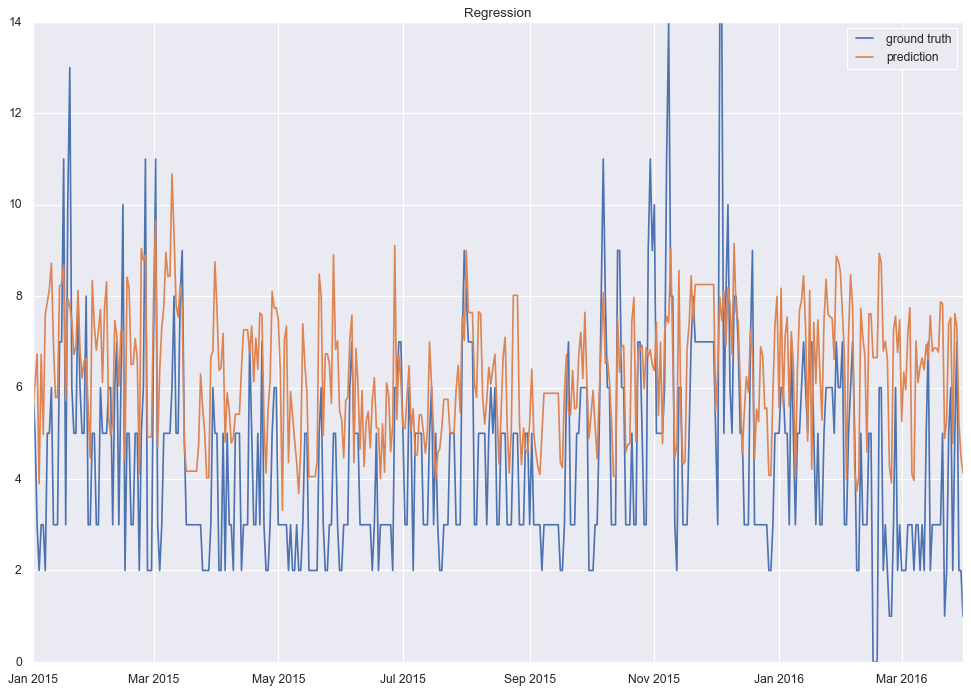

In [135]:
plt.plot(regression2[split:])
plt.legend(['ground truth','prediction'])
plt.title('Regression')
plt.savefig('Regression_kansas.png', dpi = 500)
plt.show

# Threshold berechnen

In [136]:
threshold_dataset = df_k

threshold_values = threshold_dataset.describe()
threshold_values.iloc[4:7,-1]

25%    3.0
50%    6.0
75%    8.0
Name: CO AQI, dtype: float64

In [137]:
def thresholds(state, dataset_actual, dataset_prediction):

    def getCount(listOfElems, cond = None):
        'Returns the count of elements in list that satisfies the given condition'
        if cond:
            count = sum(cond(elem) for elem in listOfElems)
        else:
            count = len(listOfElems)    
        return count    


    def nans(shape, dtype = float):
        a = np.empty(shape, dtype)
        a.fill(np.nan)
        return a

    column_names = [state,'Actual', 'Prediction', 'Rel. Diff.']
    table_empty = nans([4, 4]) # auf [4,5] wechseln, wenn absolute Differenz auch reingenommen wird
    table_result = pd.DataFrame(table_empty, columns = column_names)
    table_result.iloc[0, 0] = 'Bad'
    table_result.iloc[1, 0] = 'Moderate'
    table_result.iloc[2, 0] = 'Good'
    table_result.iloc[3, 0] = 'Total'

    # actual values

    bad_a = getCount(dataset_actual, lambda x : x >= threshold_values.iloc[6,-1])
    table_result.iloc[0, 1] = bad_a

    moderate_a = getCount(dataset_actual, lambda x : x > threshold_values.iloc[4,-1] and x < threshold_values.iloc[6,-1])
    table_result.iloc[1, 1] = moderate_a

    good_a = getCount(dataset_actual, lambda x : x <= threshold_values.iloc[4,-1])
    table_result.iloc[2, 1] = good_a
    
    table_result.iloc[3, 1] = good_a + moderate_a + bad_a


    # predicted values

    bad_p = getCount(dataset_prediction, lambda x : x >= threshold_values.iloc[6,-1])
    table_result.iloc[0, 2] = bad_p

    moderate_p = getCount(dataset_prediction, lambda x : x > threshold_values.iloc[4,-1] and x < threshold_values.iloc[6,-1])
    table_result.iloc[1, 2] = moderate_p

    good_p = getCount(dataset_prediction, lambda x : x <= threshold_values.iloc[4,-1])
    table_result.iloc[2, 2] = good_p
    
    table_result.iloc[3, 2] = good_p + moderate_p + bad_p

    # absolute difference
    bad_da = table_result.iloc[0, 2] - table_result.iloc[0, 1]
    #table_result.iloc[0, 3] = bad_da

    moderate_da = table_result.iloc[1, 2] - table_result.iloc[1, 1]
    #table_result.iloc[1, 3] = moderate_da

    good_da = table_result.iloc[2, 2] - table_result.iloc[2, 1]
    #table_result.iloc[2, 3] = good_da

    # relative difference
    bad_dr = bad_da/table_result.iloc[0, 1]
    table_result.iloc[0, 3] = round(bad_dr,2)

    moderate_dr = moderate_da/table_result.iloc[1, 1]
    table_result.iloc[1, 3] = round(moderate_dr,2)

    good_dr = good_da/table_result.iloc[2, 1]
    table_result.iloc[2, 3] = round(good_dr,2)
    
    table_result.iloc[3, 3] = 0

    table_result = table_result.set_index(table_result[state])
    table_result = table_result.drop(axis=1, columns = state)

    def highlight_cells(val, color_if_true, color_if_false):
        color = color_if_true if abs(val) >= .1 else color_if_false
        return 'background-color: {}'.format(color)

    return table_result.style.applymap(highlight_cells, color_if_true='coral', color_if_false='', subset=['Rel. Diff.'])

In [138]:
# Regression

state = 'Kansas'

dataset_actual = df_k['CO AQI'][split:]
dataset_prediction = regression2['Prediction'][split:]

print('\033[1m\nResults Regression\033[0m')

thresholds(state, dataset_actual, dataset_prediction)


Results Regression


In [139]:
# Regression

mean_squared_error(regression2['CO AQI'], regression2['Prediction'], squared=False)

3.2171251556746396

In [140]:
# LSTM

state = 'Kansas'

dataset_actual = valid['CO AQI']
dataset_prediction = valid['Prediction']

print('\033[1m\nResults LSTM\033[0m')

thresholds(state, dataset_actual, dataset_prediction)


Results LSTM


In [141]:
# LSTM with standard paremeters

mean_squared_error(valid_st['CO AQI'], valid_st['Prediction'], squared=True) #Abweichungen aufgrund Normailisierung der Daten

0.046658801789882215

In [142]:
# LSTM with tuned parameters

mean_squared_error(valid['CO AQI'], valid['Prediction'], squared=True)

0.010024666207346995

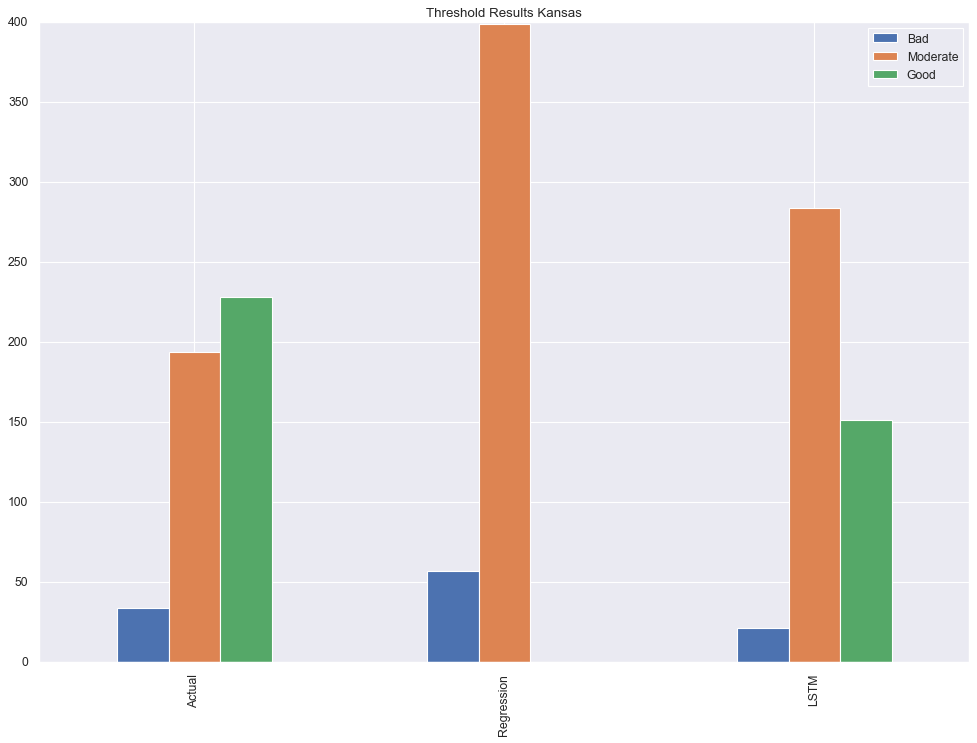

In [145]:
# create data
df = pd.DataFrame([['Actual',34,194,228], ['Regression',57,399,0], ['LSTM',21,284,151]],
                  columns=['','Bad', 'Moderate', 'Good'])

# plot grouped bar chart
df.plot(x='',
        kind='bar',
        stacked=False,
        title='Threshold Results Kansas')
plt.savefig('Results_Kansas.png', dpi = 500)